ARIMA
For this section we will be using ARIMA to predict the IBM's closing stock price closing

This model have 3 parameters - d (#of differencing) - p (order of autoregressive AR terms ) - q

In [101]:

from IPython.core.debugger import set_trace

import pandas as pd 
import numpy as np
import os 
import matplotlib.pyplot as plt 
import time
import datetime as dt

plt.style.use(style="seaborn")
%matplotlib inline


lets load in the data 

In [102]:
df = pd.read_csv("final_dataset_stocks.csv")

df.date = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.date.dtype

dtype('<M8[ns]')

In [103]:
display(df.head())

,Unnamed: 0,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,...,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
0,0,2012-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16068.824,NaN
1,1,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1257.60,--,0.00,0.00,0.00,.,16068.824,NaN
2,2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.97998,...,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.22998,...,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.22998,...,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02


In [104]:
#We will drop the index column that came with the dataset 

df.drop(columns=['Unnamed: 0'], inplace=True)

#we will drop the rows that includes na
#The rows with NaN are days when market was closed. I will be deleting those rows.

df.dropna(inplace=True)
df.head()

,date,IBM_open,IBM_high,IBM_low,IBM_close,IBM_volume,NASDAQ_open,NASDAQ_high,NASDAQ_low,NASDAQ_close,NASDAQ_Adj_close,NASDAQ_volume,SP_close,SP_Volume,SP_Open,SP_High,SP_low,interest_rate,gdp,yield_rate
2,2012-01-03,124.5256,125.8460,124.0388,124.2388,5646000.0,2657.389893,2665.899902,2641.979980,2648.719971,2648.719971,1.636850e+09,1277.06,--,1258.86,1284.62,1258.86,2.01,16068.824,1.97
3,2012-01-04,123.7520,124.2589,123.3319,123.7320,4346700.0,2639.899902,2653.179932,2627.229980,2648.360107,2648.360107,1.670530e+09,1277.30,--,1277.03,1278.73,1268.10,2.08,16068.824,2.00
4,2012-01-05,123.2452,123.3919,122.1048,123.1452,4463100.0,2642.570068,2673.560059,2631.229980,2669.860107,2669.860107,1.836410e+09,1281.06,--,1277.30,1283.05,1265.26,2.12,16068.824,2.02
5,2012-01-06,122.9651,123.0251,121.5780,121.7314,4897100.0,2671.169922,2682.120117,2658.830078,2674.219971,2674.219971,1.683090e+09,1277.81,--,1280.93,1281.84,1273.34,2.09,16068.824,1.98
8,2012-01-09,121.5047,121.5513,120.2176,121.0979,5201200.0,2682.979980,2683.780029,2662.959961,2676.560059,2676.560059,1.768080e+09,1280.70,--,1277.83,1281.99,1274.55,2.11,16068.824,1.98


The arima model requires the data to be stationary. - D terms 

- Subtract the previous values form the current vlaue. Now if we just difference once, we might not get a stationary series so will need to do that multiple times. And the minimum number of differene operations needed to make the series stationary needs to be imputed into our ARIMA model.

We will use the ADF test 
The augumented dickey fuller test can check if the price is stationary 
the Null hypi if ADF is that the time series is not-stationary, so, if the p-value of the test is less than sig-level 0.05 then we can reject the null and infer that the time serices is indeed stationary. 

In [105]:
#check if IBM closing price is stationary 

from statsmodels.tsa.stattools import adfuller 
result = adfuller(df.IBM_close.dropna())
print(f"ADF Stats = {result[0]}")
print(f"ADF P-V = {result[1]}")


ADF Stats = -2.9354955749674247
ADF P-V = 0.04137331538666607


It is stationary

ACF - autocorrelation function

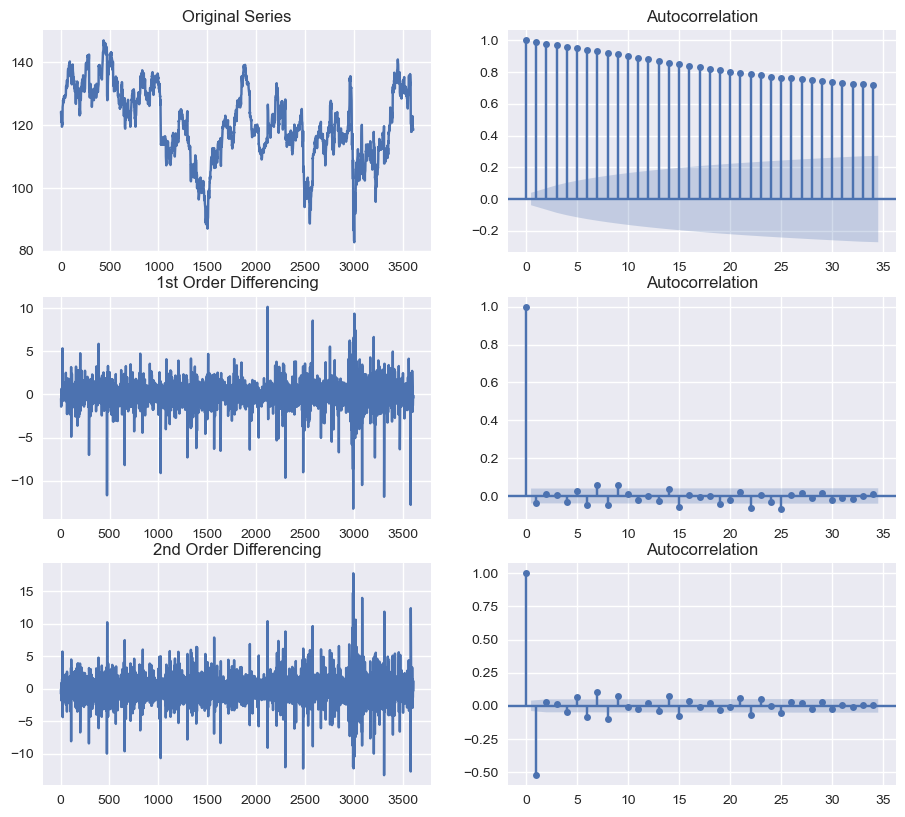

In [153]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(11,10), 'figure.dpi':100})

# Import data
#df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.IBM_close); 
axes[0, 0].set_title('Original Series');
plot_acf(df.IBM_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.IBM_close.diff());
axes[1, 0].set_title('1st Order Differencing');
plot_acf(df.IBM_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.IBM_close.diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing');
plot_acf(df.IBM_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
# plt.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=10, top=10, wspace=10, hspace=3)
#display(df)

In [154]:
# we wull use the pmdarima pkg to get the number of differencing 
#!conda install -c conda-forge pmdarima
# !pip install pmdarima


In [155]:
from pmdarima.arima.utils import ndiffs

In [175]:
#ADF test
print(ndiffs(df.IBM_close,test="adf"))#0

# KPSS test
print(ndiffs(df.IBM_close, test='kpss'))  # 1

# PP test:
print(ndiffs(df.IBM_close, test='pp'))  # 0

0
1
0


ndiff is the function that gives the number of differencing - from the test we do not need any differencing, thats similar to saying that IBM closing stock price have no seasonality.

The P term

We continue to the p terms 
P is the order of the AR term. it refers to the number of lags to be used as predictors. 
we caj f9jd 08t tue required number of AR terms by inspecting the partial autocorrelation plot. 

the partial autocorrelation represents the correlation between the series and its lags


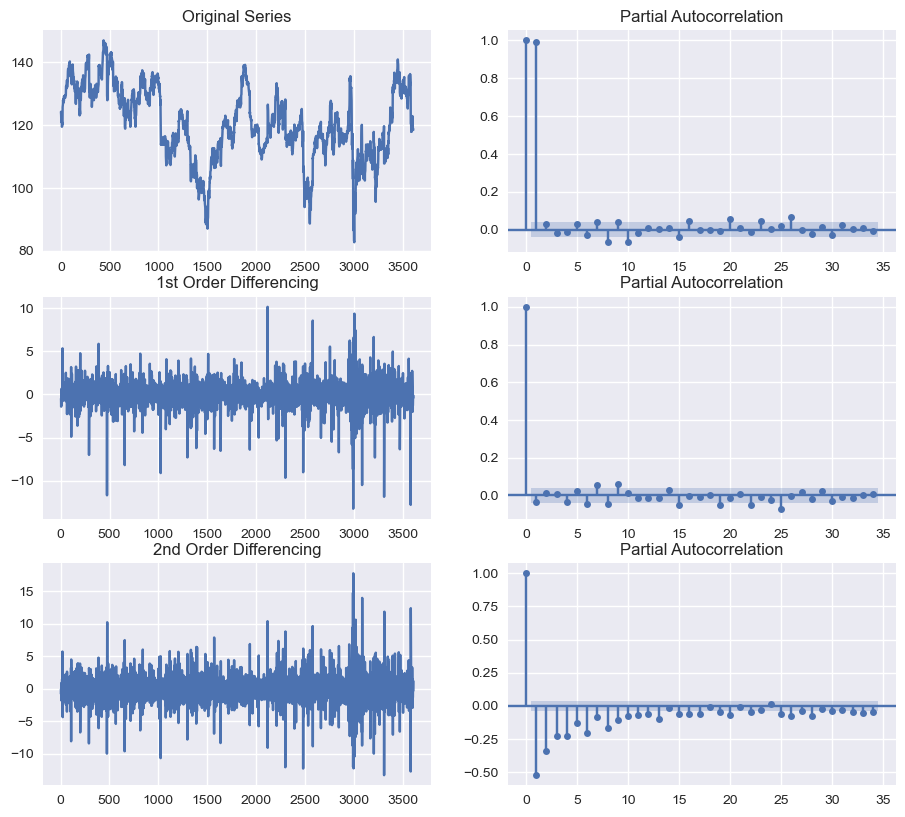

In [157]:

#check for p terms

# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(df.IBM_close); 
axes[0, 0].set_title('Original Series');
plot_pacf(df.IBM_close, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.IBM_close.diff());
axes[1, 0].set_title('1st Order Differencing');
plot_pacf(df.IBM_close.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.IBM_close.diff().diff()); 
axes[2, 0].set_title('2nd Order Differencing');
plot_pacf(df.IBM_close.diff().diff().dropna(), ax=axes[2, 1])

plt.show()
# plt.tight_layout()
# plt.subplots_adjust(left=None, bottom=None, right=10, top=10, wspace=10, hspace=3)


q terms is the order of the MA ter, (movgin average). it regers to the number of ladded forecast errors that should go into the ARIMA Model
We can loot at the ACF plot for the number of MA terms

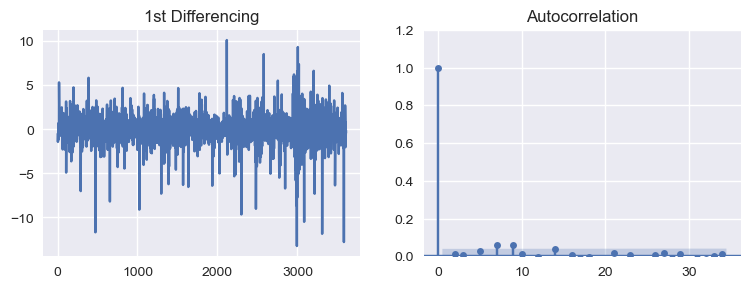

In [164]:


plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})
fig, axes = plt.subplots(1, 2)
axes[0].plot(df.IBM_close.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.IBM_close.diff().dropna(), ax=axes[1])
plt.show()

here we see that 2 lags are above the line of significance around 7-8 but lets fix it at something lower to be more conservative.
we will use 3 as q

# ARIMA model

In [174]:
from statsmodels.tsa.arima_model import ARIMA

# 1,0,3 ARIMA Model
model = ARIMA(df.IBM_close, order=(1,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will

                              ARMA Model Results                              
Dep. Variable:              IBM_close   No. Observations:                 2486
Model:                     ARMA(1, 3)   Log Likelihood               -4777.549
Method:                       css-mle   S.D. of innovations              1.652
Date:                Sun, 05 Dec 2021   AIC                           9567.098
Time:                        21:07:07   BIC                           9602.009
Sample:                             0   HQIC                          9579.776
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             120.6455      2.957     40.803      0.000     114.850     126.441
ar.L1.IBM_close     0.9892      0.003    337.151      0.000       0.983       0.995
ma.L1.IBM_close    -0.0298      

The model looks like it has insignificant predictors - so we will try to remove 1 term in q and build a 1,1,2 model 


In [179]:
# 1,0,2 ARIMA Model
model = ARIMA(df.IBM_close, order=(1,0,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will

                              ARMA Model Results                              
Dep. Variable:              IBM_close   No. Observations:                 2486
Model:                     ARMA(1, 2)   Log Likelihood               -4777.636
Method:                       css-mle   S.D. of innovations              1.652
Date:                Sun, 05 Dec 2021   AIC                           9565.271
Time:                        21:10:40   BIC                           9594.364
Sample:                             0   HQIC                          9575.836
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             120.6466      2.979     40.501      0.000     114.808     126.485
ar.L1.IBM_close     0.9894      0.003    344.365      0.000       0.984       0.995
ma.L1.IBM_close    -0.0306      

It looks like we can improve it a bit more 

In [182]:
# 1,0,1 ARIMA Model
model = ARIMA(df.IBM_close, order=(1,0,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will

                              ARMA Model Results                              
Dep. Variable:              IBM_close   No. Observations:                 2486
Model:                     ARMA(1, 1)   Log Likelihood               -4778.028
Method:                       css-mle   S.D. of innovations              1.652
Date:                Sun, 05 Dec 2021   AIC                           9564.056
Time:                        21:12:17   BIC                           9587.330
Sample:                             0   HQIC                          9572.508
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             120.6479      3.024     39.891      0.000     114.720     126.576
ar.L1.IBM_close     0.9898      0.003    354.713      0.000       0.984       0.995
ma.L1.IBM_close    -0.0301      

Lets plot the residual errors 

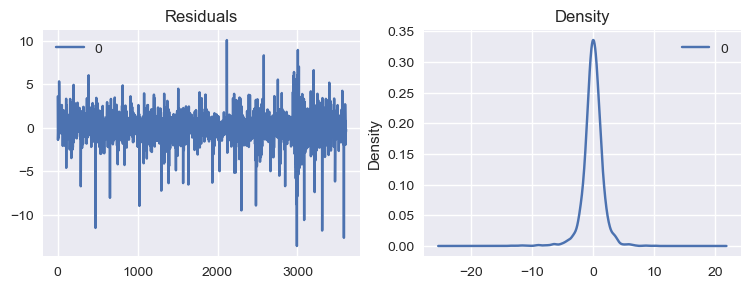

In [183]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Now we compare to see how well our model did! 

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

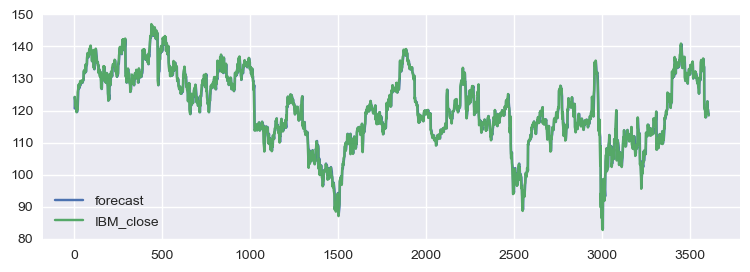

In [185]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
#plt.xlabel(df.date)
plt.show()

The model looks quite good, however this is the comparing to the training data so we cannot conclude if it is good! 

We need to validate using the out of time cv

In [190]:
from statsmodels.tsa.stattools import acf

# Create Training and Test
train = df.IBM_close[:int(0.8*(len(df)))]
test = df.IBM_close[int(0.8*(len(df))):]

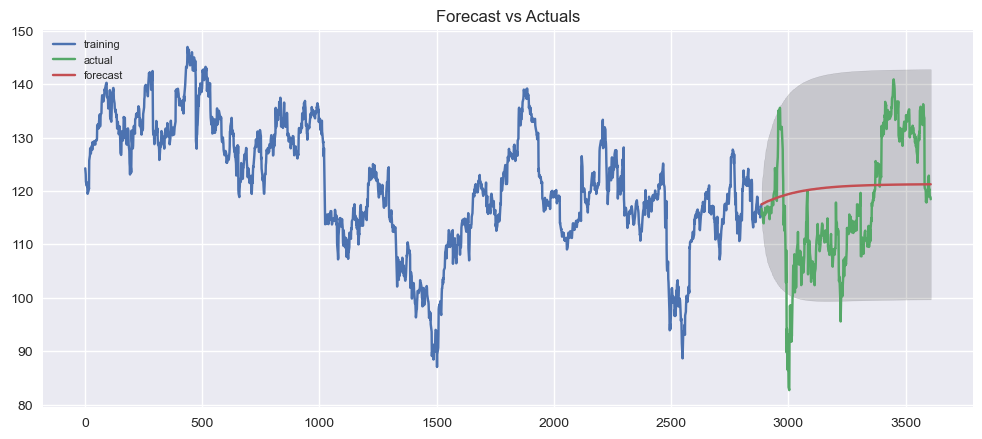

In [210]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 0, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(498, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Lets look at the accuracy of this model!

In [212]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    mse = np.mean((forecast - actual)**2)       # MSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'MAPE':mape, 'ME':me, 'MAE': mae, 
            'MPE': mpe, 'RMSE':rmse,'MSE':mse, 'ACF1':acf1, 
            'CORR':corr, 'MINMAX':minmax})

forecast_accuracy(fc, test.values)

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


{'MAPE': 0.08846939671008607,
 'ME': 2.8812998236725247,
 'MAE': 10.063348648174184,
 'MPE': 0.03448773002598661,
 'RMSE': 11.718982511936252,
 'MSE': 137.3345511150677,
 'ACF1': 0.9797069644766767,
 'CORR': 0.31028440210499286,
 'MINMAX': 0.08078628194756121}

# VAR model 

In [168]:
#creating the train and validation set
train = df[:int(0.8*(len(df)))]
valid = df[int(0.8*(len(df))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

# SS codes

In [112]:
from statsmodels.graphics.tsaplots import plot_pacf

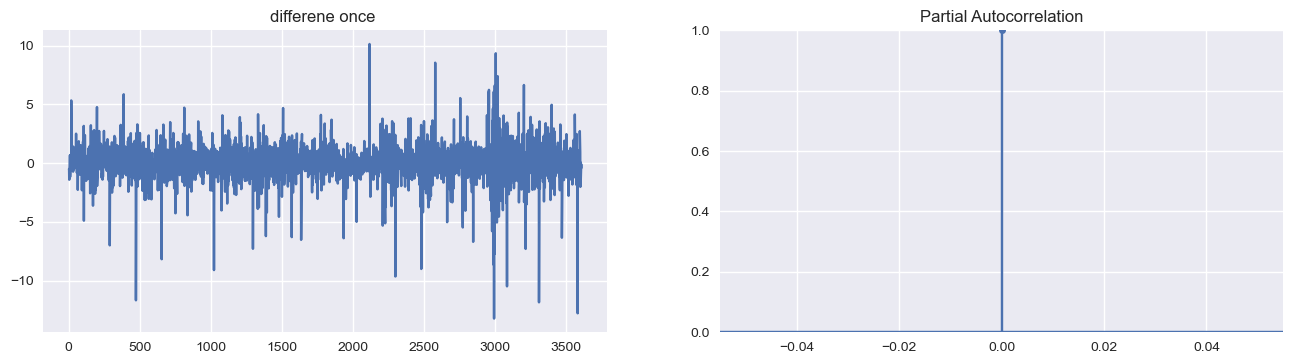

In [178]:
diff = df.IBM_close.diff()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("differene once ")

ax2.set_ylim(0,1)
plot_pacf(diff, ax=ax2);

/Users/andyc/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


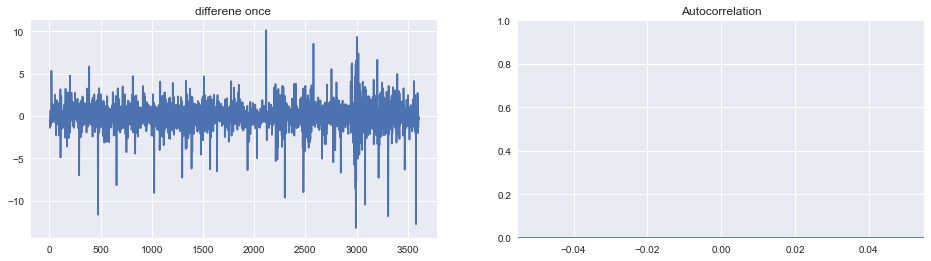

In [114]:
diff = df.IBM_close.diff()

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(diff)
ax1.set_title("differene once ")
ax2.set_ylim(0,1)
plot_acf(diff, ax=ax2);

In [106]:
from statsmodels.graphics.tsaplots import plot_acf

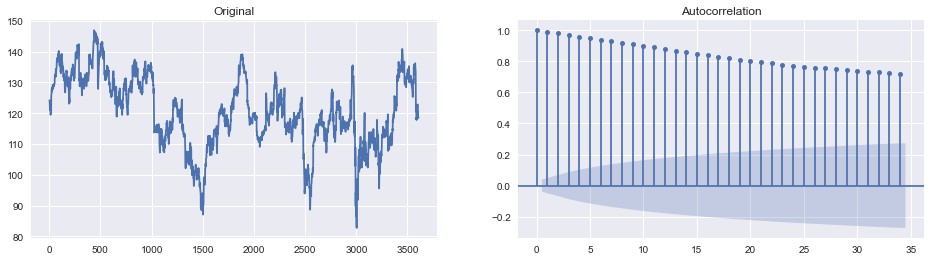

In [107]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,4))

ax1.plot(df.IBM_close)
ax1.set_title("Original")
#ass; at the end of the plot function so that the plot is not duplicated 
plot_acf(df.IBM_close, ax=ax2);
